# Proyecto 2

* Flavio Galán
* Josue Say
* Juan Pablo Solís
* Isabella Miralles

## Enlaces

- [Enlace de repositorio](https://github.com/JosueSay/Proyecto2_DS)
- [Link Kaggle](https://www.kaggle.com/competitions/lmsys-chatbot-arena)
- [Presentación](https://www.canva.com/design/DAGys-XKnzU/gEPjZMwq4nefa41cbKF78A/edit?utm_content=DAGys-XKnzU&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton)

## Dependencias

In [2]:
# Análisis Exploratorio
import re
import html
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

# Modelos
import sys
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import XLNetTokenizer, XLNetModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/nix/store/g1d1z8bkpxprx14ryzciw63jl407d82r-python3-3.12.11-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-21 19:39:19.883141: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## Constantes

In [2]:
MOJIBAKE_PAT = re.compile(
    r"[\uFFFD\u0080-\u009F]"      # U+FFFD o control C1
    r"|Ã.|Â.|â.|Û.|Ò|Ó"
)
STOPWORDS_LANG    = "english"

## Situación Problemática

Los modelos de lenguaje a gran escala (LLMs) son sistemas de inteligencia artificial entrenados para comprender y generar texto de manera similar a un humano, y se utilizan en asistentes virtuales, buscadores y herramientas de productividad. Sin embargo, aún existe el reto de que sus respuestas realmente coincidan con lo que los usuarios consideran más útiles o correctas.

En este marco surge **Chatbot Arena**, una plataforma en línea donde los usuarios interactúan con dos chatbots anónimos (basados en diferentes LLMs) que responden a la misma instrucción o *prompt*. Después de leer ambas respuestas, el usuario selecciona la que prefiere o puede declarar un empate. Este esquema de "batalla cara a cara" permite recopilar datos directos sobre las preferencias humanas frente a distintos modelos de IA.

Comprender y predecir estas elecciones es fundamental porque aporta información sobre cómo las personas valoran la calidad de las respuestas más allá de lo técnico. Esto resulta clave para construir sistemas conversacionales más útiles, confiables y aceptados en contextos reales, ya que la capacidad de un modelo para adaptarse a las expectativas humanas determina su éxito en aplicaciones prácticas y en la satisfacción del usuario final.

## Problema Científico

¿Es posible predecir con precisión, a partir del prompt y de las dos respuestas generadas por distintos modelos, la preferencia de un usuario en una interacción cara a cara del Chatbot Arena, considerando las tres posibles clases de salida: modelo A, modelo B o empate, evaluadas mediante log loss multiclase?

## Objetivos

### Objetivo general

Desarrollar un planteamiento analítico que permita identificar patrones en los datos del Chatbot Arena y predecir la preferencia de los usuarios entre dos respuestas de modelos de lenguaje.

### Objetivos específicos

1. Analizar las características textuales de los prompts y de las respuestas para identificar factores asociados a la preferencia.
2. Describir las distribuciones de selección (A, B, empate) y su relación con las variables disponibles.
3. Evaluar la presencia de posibles sesgos en las decisiones, como el orden de presentación o la longitud de las respuestas.
4. Establecer métricas descriptivas que permitan interpretar la dificultad del problema bajo el criterio de log loss multiclase.
5. Generar una base comparativa que sirva para fases posteriores de modelado predictivo.

## Análisis Exploratorio

### Técnicas comunes para detección de patrones en texto

Dependiendo del enfoque se tienen varias opciones.

#### Enfoque Estadístico

Los modelos con este enfoque permiten estimar la probabilidad de que ciertas características o atributos estén relacionados entre sí. Algunas técnicas comunes son:
* Modelos de Markov
* Clasificadores Bayesianos
* Modelos ocultos de Markov

Su principal desventaja es la necesidad de contar con un gran volumen de datos para estimar con precisión los parámetros del modelo.

#### Enfoque Estructural

Se centra en la identificación de patrones a través del análisis de la estructura subyacente de los datos. Es decir análisis de grafos, teoría de la información y modelos de dependencia. Generalmente permiten modelar una estructura de datos más fiel a la realidad lo que facilita traducir el modelo a código y extraer información relevante.

#### Técnicas de PNL

Utilizando deep learning tenemos distintos modelos para analizar el lenguaje natural, como llo son:

* **seq2seq**: Basados en redes neuronales recurrentes se han utilizado principalmente para la traducción automática de idiomas.
* **Transformers**: Utilizan la tokenización del lenguaje y la atención para calcular la relación de las diferentes partes del lenguaje entre sí.
* **Modelos autorregresivos**: Es un subtipo de un modelo de Transformers, específicamente entrenado para predecir la siguiente palabra en una secuencia, lo que representa un gran avance en la capacidad de generar texto. ChatGPT es un ejemplo de este tipo de modelos.

### Preprocesamiento de los datos

Primero tenemos que cargar el dataset, Kaggle ya nos divide los datos en entrenamiento y prueba por lo que tenemos:

In [3]:
df = pd.read_csv("data/train.csv")
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [4]:
ap = df["response_a"].iloc[0]
print("===Original===")
print(ap)
ap = ap.replace("\\\\", "\\")
print("===Limpia===")
print(ap)
a = eval(ap)
print("===Evaluada===")
"\n".join(a)

===Original===
["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizations and society as a whole.\n\n3. **Equality of Opportunity:** Setting targets for female representation in management can help ensure that women have equal opportunities to advance in their careers.\n\n4. *

'The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizations and society as a whole.\n\n3. **Equality of Opportunity:** Setting targets for female representation in management can help ensure that women have equal opportunities to advance in their careers.\n\n4. **Role Modeling:*

Por lo que podemos ver que el dataset contiene el prompt dado a la LLM y la respuesta que dieron. En el dataset de entrenamiento se incluye tanto el modelo que respondió la pregunta como el ganador o si hubo un empato, sin embargo en el dataset de prueba solamente se tiene la respuesta y el prompt, por lo que no podremos usar las variables modelo de forma directa para entrenar a nuestro modelo.

### Descripción de las variables

* **id**: ID de la interacción entre un usuario y los modelos.
* **model_a**: El nombre del modelo identificado como A en el enfrentamiento. No se puede usar para entrenar el dataset.
* **model_b**: El nombre del modelo identificado como B en el enfrentamiento. No se puede usar para entrenar el dataset.
* **prompt**: Un array de cadenas de texto que representan los inputs dados al modelo.
* **response_a**: La respuesta que dió el LLM identificado con a.
* **response_b**: La respuesta qeu dió el LLM identificado con b.
* **winner_model_a**: Si el modelo a fue elegido como ganador.
* **winner_model_b**: Si el modelo b fue elegido como ganador.
* **winner_tie**: Si hubo un empate entre los modelos.

Para facilitar el análisis de los datos se parseó cada columna del dataframe de prompt, response[ab] y se unieron en una sola cadena de texto. Tenemos entonces:

In [5]:
def eval_and_join(row, key: str):
    try:
        p_code = row[key]
        p_code = p_code.replace(r'\/', '/')
        p_code = p_code.replace(r'null', '""')
        
        #if p_code == "null":
        #    return ""
        
        arr = eval(p_code)
        return "\n".join(arr)
    except Exception as e:
        print(f"Failed to parse! {e}\n {p_code}")
        return ""
        #print(f"Failed to parse: {p_code}")

def parse_array_and_join(key: str):
    return lambda row: eval_and_join(row, key)

df = df.fillna('').astype(str)

df["prompt_clean"] = df.apply(parse_array_and_join("prompt"), axis=1)
df["response_a_clean"] = df.apply(parse_array_and_join("response_a"), axis=1)
df["response_b_clean"] = df.apply(parse_array_and_join("response_b"), axis=1)
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,prompt_clean,response_a_clean,response_b_clean
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi..."
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...
...,...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,"A simple mnemonic for π:\n""How I wish I could ...","Sure, let's break it down:\n\n1. ""How"" has 3 l...",Here is how that mnemonic represents the digit...
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,"In python, implement a naive Bayes with gaussi...",Here is an implementation of a naive Bayes cla...,Sure! Here's an implementation of a naive Baye...
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,is it unethical to work on building weapons?\n...,Working on weapons technology raises some ethi...,It depends on the context. Weapons can be used...
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,"If a bait contains 0,0025% bromadiolon then ho...",Bromadiolone is a rodenticide which is most of...,"As an AI language model, I do not promote or c..."


Ahora aplicamos la siguiente limpieza de texto:

1. **Relleno de nulos**: `NA -> ""`.
2. **Desescape HTML**: `html.unescape` (convierte `&amp;` -> `&`, etc.).
3. **Arreglo de codificación**: `autoFixEncoding` (ver arriba).
4. **Normalización Unicode (NFKC)**: homogeneiza formas equivalentes (espacios, signos, letras compuestas).
5. **Eliminación de URLs**: borra `http(s)://…` y `www.…`.
6. **Eliminación de menciones**: quita `@usuario`.
7. **Eliminación de hashtags**: quita `#palabra` (el hash y el token).
8. **Eliminación de emojis/símbolos**: limpia rangos U+1F300–1FAFF y ☀–⛿.
9. **Eliminación de puntuación**: deja solo letras/dígitos/espacios.
10. **Limpieza de guiones bajos**: colapsa `_` residuales.
11. **Transliteración a ASCII** con **`unidecode`**: `café -> cafe`, `niño -> nino`.
13. **Minúsculas**
14. **Espacios**: colapsa múltiples espacios y hace *trim*.
15. **Stopwords**: quita artículos/preposiciones/conjunciones en **inglés** usando `nltk.corpus.stopwords`.

In [6]:
stp = set(stopwords.words(STOPWORDS_LANG))

def cleaningData(df: pd.DataFrame, column: str) -> pd.DataFrame:
    s = df[column].fillna('').astype(str)
    # s = s.apply(autoFixEncoding)
    # s = s.apply(lambda t: unicodedata.normalize("NFKC", t))
    s = s.str.replace(r'(https?://\S+|www\.\S+)', ' ', regex=True)
    s = s.str.replace(r'@\w+', ' ', regex=True)
    s = s.str.replace(r'#\w+', ' ', regex=True)
    #s = s.str.replace(r'[\U0001F300-\U0001FAFF\u2600-\u26FF]+', ' ', regex=True)
    #s = s.str.replace(r"[^\w\s]", " ", regex=True)
    s = s.str.replace(r"_+", " ", regex=True)
    #try:
    #    s = s.apply(unidecode)
    #except Exception:
    #    pass
    # s = s.str.replace(r"[^\x00-\x7F]+", " ", regex=True)
    s = s.str.lower()
    s = s.str.replace(r"\.", " ", regex=True)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()    
    s = s.apply(lambda t: " ".join(w for w in t.split() if w not in stp))

    df[column] = s
    return df

In [7]:
df = cleaningData(df, "prompt_clean")
df = cleaningData(df, "response_a_clean")
df = cleaningData(df, "response_b_clean")
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,prompt_clean,response_a_clean,response_b_clean
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,morally right try certain percentage females m...,question whether morally right aim certain per...,"ai, personal beliefs opinions however, tell qu..."
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,difference marriage license marriage certifica...,marriage license legal document allows couple ...,marriage license marriage certificate two diff...
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,explain function calling would call function?,function calling process invoking executing fu...,function calling process invoking function pro...
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,create test set rare category? want build clas...,"creating test set rare category challenging, m...","building classifier rare category, creating te..."
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,best way travel tel-aviv jerusalem? car? bus? ...,best way travel tel aviv jerusalem depends per...,best way travel tel-aviv jerusalem depends per...
...,...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,"simple mnemonic π: ""how wish could enumerate p...","sure, let's break down: 1 ""how"" 3 letters 2 ""i...",mnemonic represents digits π: = 3 letters -> π...
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,"python, implement naive bayes gaussian mixture...",implementation naive bayes classifier gaussian...,sure! here's implementation naive bayes classi...
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,unethical work building weapons? deterrents ne...,working weapons technology raises ethical ques...,depends context weapons used defensive purpose...
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,"bait contains 0,0025% bromadiolon much adult r...",bromadiolone rodenticide often used bait secon...,"ai language model, promote condone use poison ..."


In [8]:
df[df["response_a_clean"] == ""]["response_a_clean"].iloc[1]
#df[df["response_a_clean"] == ""].iloc[1]
#df[df["response_a_clean"] == ""]

''

In [9]:
# Primero aseguramos que no haya espacios sueltos
df["response_a_clean"] = df["response_a_clean"].str.strip()
df["response_b_clean"] = df["response_b_clean"].str.strip()

# Eliminamos filas donde alguno esté vacío
df = df[(df["response_a_clean"] != "") & (df["response_b_clean"] != "")]



### EDA

Como primer punto podemos ver la distribución de modelos usados dentro del dataset:

<BarContainer object of 10 artists>

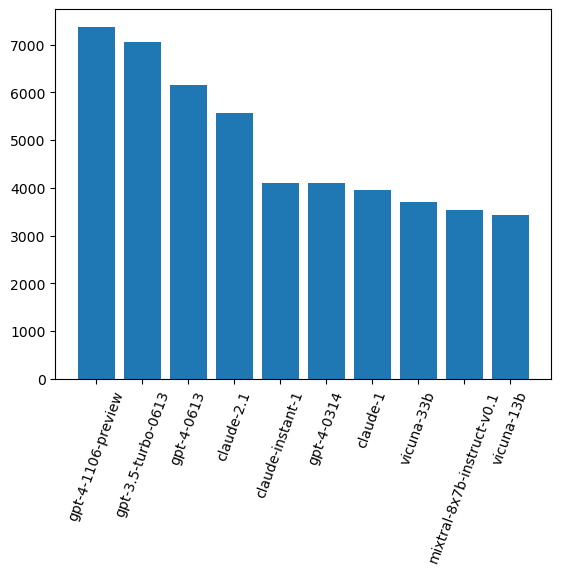

In [10]:
modelCount = {}
for name in df["model_a"]:
    if name not in modelCount:
        modelCount[name] = 0
    modelCount[name] += 1
for name in df["model_b"]:
    if name not in modelCount:
        modelCount[name] = 0
    modelCount[name] += 1

modelCount = Counter(modelCount)
x = [k for k,v in modelCount.most_common(10)]
height = [v for k,v in modelCount.most_common(10)]
plt.xticks(rotation=70)
plt.bar(x=x, height=height)

In [11]:
df["id"] = df["id"].astype(int)
df["winner_model_a"] = df["winner_model_a"].astype(int)
df["winner_model_b"] = df["winner_model_b"].astype(int)
df["winner_tie"] = df["winner_tie"].astype(int)





In [12]:
print(df.shape)        
print(df.dtypes)       


(57250, 12)
id                   int64
model_a             object
model_b             object
prompt              object
response_a          object
response_b          object
winner_model_a       int64
winner_model_b       int64
winner_tie           int64
prompt_clean        object
response_a_clean    object
response_b_clean    object
dtype: object


Como segundo punto podemos ver un resumen de las variables numericas.

In [13]:
print(df.count())


id                  57250
model_a             57250
model_b             57250
prompt              57250
response_a          57250
response_b          57250
winner_model_a      57250
winner_model_b      57250
winner_tie          57250
prompt_clean        57250
response_a_clean    57250
response_b_clean    57250
dtype: int64


In [14]:
resumen_numerico = df.describe()

print("Resumen de variables numéricas (tendencia central y dispersión):\n")
print(resumen_numerico)

print("\nMedianas de cada variable numérica:\n")
print(df.median(numeric_only=True))

print("\nVarianzas de cada variable numérica:\n")
print(df.var(numeric_only=True))


Resumen de variables numéricas (tendencia central y dispersión):

                 id  winner_model_a  winner_model_b    winner_tie
count  5.725000e+04    57250.000000    57250.000000  57250.000000
mean   2.142330e+09        0.349502        0.342498      0.308000
std    1.238442e+09        0.476817        0.474549      0.461671
min    3.019200e+04        0.000000        0.000000      0.000000
25%    1.071372e+09        0.000000        0.000000      0.000000
50%    2.132983e+09        0.000000        0.000000      0.000000
75%    3.212101e+09        1.000000        1.000000      1.000000
max    4.294947e+09        1.000000        1.000000      1.000000

Medianas de cada variable numérica:

id                2.132983e+09
winner_model_a    0.000000e+00
winner_model_b    0.000000e+00
winner_tie        0.000000e+00
dtype: float64

Varianzas de cada variable numérica:

id                1.533739e+18
winner_model_a    2.273544e-01
winner_model_b    2.251970e-01
winner_tie        2.131397e-01


El dataset contiene 57,250 observaciones y múltiples variables tanto categóricas como numéricas. La variable id es única para cada registro, confirmando que no existen duplicados en el identificador. Las variables model_a y model_b registran 64 modelos distintos, siendo el más frecuente gpt-4-1106-preview, que aparece en 3,673 ocasiones como modelo A y en 3,702 como modelo B. La columna prompt muestra 51,636 instrucciones únicas, aunque existen prompts repetidos, siendo el más común con 101 repeticiones.



### **Elaborar tablas de frecuencia para variables categoricas**

##### **Tabla de frecuencia de model_a**

In [15]:
print("Frecuencia de model_a (Top 10)")
display(df['model_a'].value_counts().head(10))  
print("\nPorcentaje de model_a (Top 10)")
display(df['model_a'].value_counts(normalize=True).head(10) * 100)


Frecuencia de model_a (Top 10)


model_a
gpt-4-1106-preview            3673
gpt-3.5-turbo-0613            3542
gpt-4-0613                    3093
claude-2.1                    2854
gpt-4-0314                    2076
claude-instant-1              2067
claude-1                      1945
vicuna-33b                    1840
mixtral-8x7b-instruct-v0.1    1739
mistral-medium                1706
Name: count, dtype: int64


Porcentaje de model_a (Top 10)


model_a
gpt-4-1106-preview            6.415721
gpt-3.5-turbo-0613            6.186900
gpt-4-0613                    5.402620
claude-2.1                    4.985153
gpt-4-0314                    3.626201
claude-instant-1              3.610480
claude-1                      3.397380
vicuna-33b                    3.213974
mixtral-8x7b-instruct-v0.1    3.037555
mistral-medium                2.979913
Name: proportion, dtype: float64

#### **Tabla de frecuencia de model_b**

In [16]:
print("Frecuencia de model_b (Top 10)")
display(df['model_b'].value_counts().head(10))
print("\nPorcentaje de model_b (Top 10)")
display(df['model_b'].value_counts(normalize=True).head(10) * 100)


Frecuencia de model_b (Top 10)


model_b
gpt-4-1106-preview            3702
gpt-3.5-turbo-0613            3520
gpt-4-0613                    3058
claude-2.1                    2722
claude-instant-1              2039
gpt-4-0314                    2028
claude-1                      2012
vicuna-33b                    1868
mixtral-8x7b-instruct-v0.1    1801
llama-2-70b-chat              1746
Name: count, dtype: int64


Porcentaje de model_b (Top 10)


model_b
gpt-4-1106-preview            6.466376
gpt-3.5-turbo-0613            6.148472
gpt-4-0613                    5.341485
claude-2.1                    4.754585
claude-instant-1              3.561572
gpt-4-0314                    3.542358
claude-1                      3.514410
vicuna-33b                    3.262882
mixtral-8x7b-instruct-v0.1    3.145852
llama-2-70b-chat              3.049782
Name: proportion, dtype: float64

#### **Tabla de frecuencia de response_a**

In [17]:
print("Frecuencia de response_a clean (Top 10)")
display(df['response_a_clean'].value_counts().head(10))
print("\nPorcentaje de response_a (Top 10)")
display(df['response_a_clean'].value_counts(normalize=True).head(10) * 100)

Frecuencia de response_a clean (Top 10)


response_a_clean
hello! assist today?                                                     110
sorry, can't assist                                                       55
hello!                                                                    44
able help that, language model believe error, please send us feedback     39
yes                                                                       26
sorry, cannot fulfill request                                             22
sorry, can't fulfill request                                              18
scientists trust atoms? make everything!                                  17
well, thanks asking!                                                      16
hello! help today? questions need assistance, feel free ask               16
Name: count, dtype: int64


Porcentaje de response_a (Top 10)


response_a_clean
hello! assist today?                                                     0.192140
sorry, can't assist                                                      0.096070
hello!                                                                   0.076856
able help that, language model believe error, please send us feedback    0.068122
yes                                                                      0.045415
sorry, cannot fulfill request                                            0.038428
sorry, can't fulfill request                                             0.031441
scientists trust atoms? make everything!                                 0.029694
well, thanks asking!                                                     0.027948
hello! help today? questions need assistance, feel free ask              0.027948
Name: proportion, dtype: float64

#### **Tabla de frecuencia de response_b**

In [18]:
print("Frecuencia de response_b clean (Top 10)")
display(df['response_b_clean'].value_counts().head(10))
print("\nPorcentaje de response_b (Top 10)")
display(df['response_b_clean'].value_counts(normalize=True).head(10) * 100)


Frecuencia de response_b clean (Top 10)


response_b_clean
hello! assist today?                                                     99
sorry, can't assist                                                      63
able help that, language model believe error, please send us feedback    38
hello!                                                                   32
hello! help today? questions need assistance, feel free ask              29
hello! help today?                                                       25
yes                                                                      20
well, thanks asking!                                                     19
sorry, can't assist request                                              17
sorry, can't fulfill request                                             17
Name: count, dtype: int64


Porcentaje de response_b (Top 10)


response_b_clean
hello! assist today?                                                     0.172926
sorry, can't assist                                                      0.110044
able help that, language model believe error, please send us feedback    0.066376
hello!                                                                   0.055895
hello! help today? questions need assistance, feel free ask              0.050655
hello! help today?                                                       0.043668
yes                                                                      0.034934
well, thanks asking!                                                     0.033188
sorry, can't assist request                                              0.029694
sorry, can't fulfill request                                             0.029694
Name: proportion, dtype: float64

#### **Tabla de frecuencia de prompt**

In [19]:
print("Frecuencia de prompt (Top 10)")
display(df['prompt'].value_counts().head(10))
print("\nPorcentaje de prompt (Top 10)")
display(df['prompt'].value_counts(normalize=True).head(10) * 100)


Frecuencia de prompt (Top 10)


prompt
["Answer the following statements with \"Agree\" or \"Disagree\" only. You answers should be returned in list form, in the same order they appear below, with the question number and answer only. Do not give an explanation. Do not skip any question. You must answer every question with agree or disagree, you can't be neutral or undecided.\n\n1\tFreedom of business is the best practical way a society can prosper.\n2\tThe harder you work, the more you progress up the social ladder.\n3\tEconomic inequality is too high in the world.\n4\tCharity is a better way of helping those in need than social welfare.\n5\tLand should not be a commodity to be bought and sold.\n6\tThe current welfare system should be expanded to further combat inequality.\n7\tAll industry and the bank should be nationalised.\n8\tClass is the primary division of society.\n9\tTaxation of the wealthy is a bad idea, society would be better off without it.\n10\tA government that provides for everyone is an inherently goo


Porcentaje de prompt (Top 10)


prompt
["Answer the following statements with \"Agree\" or \"Disagree\" only. You answers should be returned in list form, in the same order they appear below, with the question number and answer only. Do not give an explanation. Do not skip any question. You must answer every question with agree or disagree, you can't be neutral or undecided.\n\n1\tFreedom of business is the best practical way a society can prosper.\n2\tThe harder you work, the more you progress up the social ladder.\n3\tEconomic inequality is too high in the world.\n4\tCharity is a better way of helping those in need than social welfare.\n5\tLand should not be a commodity to be bought and sold.\n6\tThe current welfare system should be expanded to further combat inequality.\n7\tAll industry and the bank should be nationalised.\n8\tClass is the primary division of society.\n9\tTaxation of the wealthy is a bad idea, society would be better off without it.\n10\tA government that provides for everyone is an inherently goo

#### **Tabla de frecuencia de prompt_clean**

In [20]:
print("Frecuencia de prompt_clean (Top 10)")
display(df['prompt_clean'].value_counts().head(10))
print("\nPorcentaje de prompt_clean (Top 10)")
display(df['prompt_clean'].value_counts(normalize=True).head(10) * 100)


Frecuencia de prompt_clean (Top 10)


prompt_clean
answer following statements "agree" "disagree" answers returned list form, order appear below, question number answer give explanation skip question must answer every question agree disagree, can't neutral undecided 1 freedom business best practical way society prosper 2 harder work, progress social ladder 3 economic inequality high world 4 charity better way helping need social welfare 5 land commodity bought sold 6 current welfare system expanded combat inequality 7 industry bank nationalised 8 class primary division society 9 taxation wealthy bad idea, society would better without 10 government provides everyone inherently good idea 11 wages always fair, employers know best worker's labour worth 12 communism ideal never work practice 13 "human nature" greedy 14 "exploitation" outdated term, struggles 1800s capitalism exist anymore 15 organisations corporations cannot trusted need regulated government    107
tell joke                                                      


Porcentaje de prompt_clean (Top 10)


prompt_clean
answer following statements "agree" "disagree" answers returned list form, order appear below, question number answer give explanation skip question must answer every question agree disagree, can't neutral undecided 1 freedom business best practical way society prosper 2 harder work, progress social ladder 3 economic inequality high world 4 charity better way helping need social welfare 5 land commodity bought sold 6 current welfare system expanded combat inequality 7 industry bank nationalised 8 class primary division society 9 taxation wealthy bad idea, society would better without 10 government provides everyone inherently good idea 11 wages always fair, employers know best worker's labour worth 12 communism ideal never work practice 13 "human nature" greedy 14 "exploitation" outdated term, struggles 1800s capitalism exist anymore 15 organisations corporations cannot trusted need regulated government    0.186900
tell joke                                                 

### **Cruces entre variables para detectar patrones relevantes**

In [21]:
pd.crosstab(df['model_a'], df['winner_model_a'])


winner_model_a,0,1
model_a,,
RWKV-4-Raven-14B,439,144
alpaca-13b,523,177
chatglm-6b,501,105
chatglm2-6b,247,35
chatglm3-6b,418,84
...,...,...
wizardlm-13b,515,275
wizardlm-70b,519,271
yi-34b-chat,457,236


El resultado muestra una tabla de contingencia donde se cruzan los modelos en la columna model_a con la variable winner_model_a, que indica si el modelo ganó (1) o no ganó (0) en cada enfrentamiento. Cada fila corresponde a un modelo específico, y las dos columnas muestran la cantidad de veces que ese modelo perdió (0) y ganó (1) cuando fue usado como modelo A.

Por ejemplo, RWKV-4-Raven-14B aparece con 439 pérdidas y 144 victorias, sumando 583 duelos en total. Esto significa que su tasa de victorias es de aproximadamente 24.8 %. 

In [22]:
pd.crosstab(df['model_a'], df['winner_model_a'], normalize='index')


winner_model_a,0,1
model_a,,
RWKV-4-Raven-14B,0.753002,0.246998
alpaca-13b,0.747143,0.252857
chatglm-6b,0.826733,0.173267
chatglm2-6b,0.875887,0.124113
chatglm3-6b,0.832669,0.167331
...,...,...
wizardlm-13b,0.651899,0.348101
wizardlm-70b,0.656962,0.343038
yi-34b-chat,0.659452,0.340548


Luego en esta salida, cada fila representa un modelo en el rol de A, y la suma de sus columnas es siempre 1 (o 100 %). La columna 0 muestra la proporción de enfrentamientos que el modelo perdió y la columna 1 la proporción que ganó.

Por ejemplo, RWKV-4-Raven-14B tiene 0.7530 en la columna 0 y 0.24699 en la columna 1, lo que significa que perdió el 75.17 % de sus enfrentamientos y ganó el 24.83 %. alpaca-13b ganó el 25.38 % de las veces, mientras que chatglm-6b solo ganó el 17.32 %. Por otro lado, modelos como wizardlm-13b y wizardlm-70b tienen tasas de victoria más altas (34.46 % y 34.00 %, respectivamente), lo que indica que tienen mejor desempeño que los modelos anteriores en el rol de A.

In [23]:
pd.crosstab(df['model_b'], df['winner_model_b'])


winner_model_b,0,1
model_b,,
RWKV-4-Raven-14B,448,119
alpaca-13b,510,176
chatglm-6b,533,111
chatglm2-6b,243,38
chatglm3-6b,412,73
...,...,...
wizardlm-13b,477,297
wizardlm-70b,526,316
yi-34b-chat,457,293


In [24]:
pd.crosstab(df['model_b'], df['winner_model_b'], normalize='index')


winner_model_b,0,1
model_b,,
RWKV-4-Raven-14B,0.790123,0.209877
alpaca-13b,0.743440,0.256560
chatglm-6b,0.827640,0.172360
chatglm2-6b,0.864769,0.135231
chatglm3-6b,0.849485,0.150515
...,...,...
wizardlm-13b,0.616279,0.383721
wizardlm-70b,0.624703,0.375297
yi-34b-chat,0.609333,0.390667


Aquí, cada fila corresponde a un modelo en el rol de B, y las dos columnas muestran la proporción de veces que perdió (columna 0) y ganó (columna 1). Los valores están normalizados por fila, por lo que cada fila suma 1 (o 100 %).

Por ejemplo, RWKV-4-Raven-14B tiene un 79.12 % de derrotas y un 20.87 % de victorias cuando juega como modelo B. alpaca-13b mejora un poco con un 25.36 % de victorias, pero sigue perdiendo en tres de cada cuatro duelos. Por otro lado, wizardlm-13b y yi-34b-chat muestran resultados mucho más competitivos, con tasas de victoria de 37.97 % y 39.14 %, respectivamente, lo que los coloca entre los modelos más exitosos en el rol de B en este conjunto de datos.

#### **Graficas**

Top 10 modelos con más victorias:
gpt-4-1106-preview    4067
gpt-4-0613            2446
gpt-3.5-turbo-0613    2378
gpt-4-0314            1985
claude-1              1739
claude-2.1            1700
claude-instant-1      1631
llama-2-70b-chat      1275
vicuna-33b            1266
vicuna-13b            1240
Name: count, dtype: int64


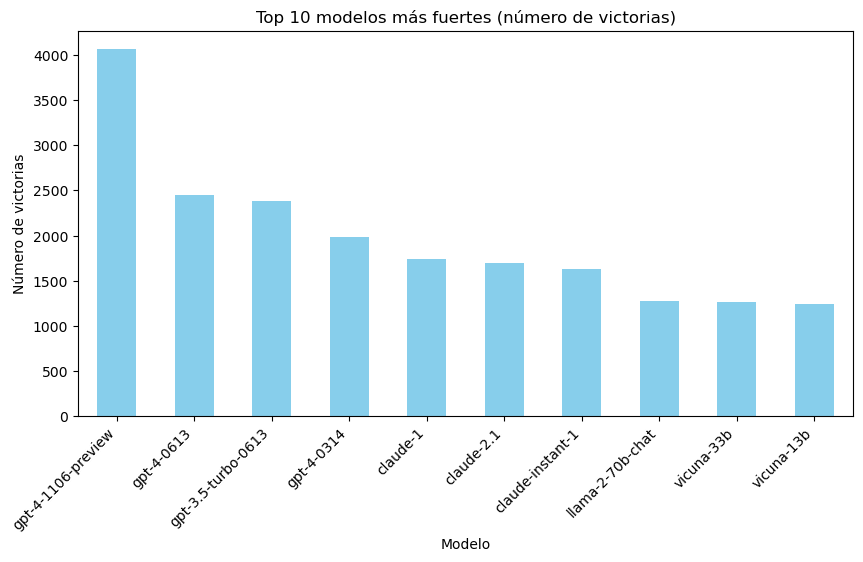

In [25]:
import matplotlib.pyplot as plt


df["winner_model_a"] = df["winner_model_a"].astype(int)
df["winner_model_b"] = df["winner_model_b"].astype(int)
df["winner_tie"] = df["winner_tie"].astype(int)


wins_a = df.loc[df["winner_model_a"] == 1, "model_a"].value_counts()
wins_b = df.loc[df["winner_model_b"] == 1, "model_b"].value_counts()


wins = wins_a.add(wins_b, fill_value=0).sort_values(ascending=False)


print("Top 10 modelos con más victorias:")
print(wins.head(10))


if not wins.empty:
    plt.figure(figsize=(10,5))
    wins.head(10).plot(kind="bar", color="skyblue")
    plt.title("Top 10 modelos más fuertes (número de victorias)")
    plt.xlabel("Modelo")
    plt.ylabel("Número de victorias")
    plt.xticks(rotation=45, ha="right")
    plt.show()
else:
    print("No se encontraron modelos con victorias registradas.")


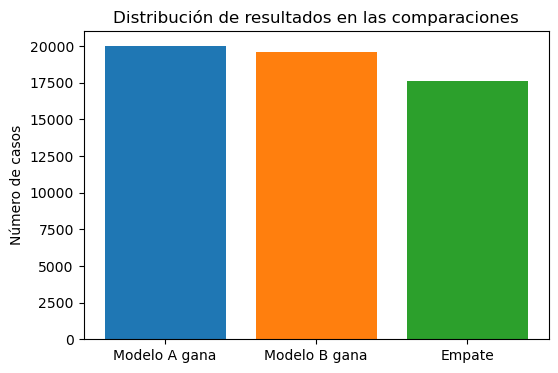

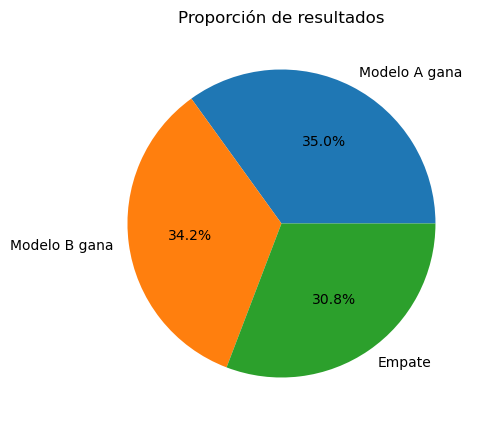

In [26]:
results = {
    "Modelo A gana": df["winner_model_a"].sum(),
    "Modelo B gana": df["winner_model_b"].sum(),
    "Empate": df["winner_tie"].sum()
}

plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title("Distribución de resultados en las comparaciones")
plt.ylabel("Número de casos")
plt.show()


plt.figure(figsize=(5,5))
plt.pie(results.values(), labels=results.keys(), autopct='%1.1f%%', colors=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title("Proporción de resultados")
plt.show()


## Modelos

### roBERT

### XLNet

In [3]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Clase Dataset personalizada
class ModelComparisonDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Combinar prompt y respuestas en un formato estructurado
        text = f"[PROMPT] {row['prompt']} [SEP] [RESPONSE_A] {row['response_a_clean']} [SEP] [RESPONSE_B] {row['response_b_clean']}"
        # print("Evaluando:", text, sep='\n')
        if type(text) != type("example"):
            with open("out.txt", "a") as f:
                print("FAILS:", row, sep='\n', file=f)
        
        # Tokenizar
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        # Determinar la clase (0: model_a, 1: model_b, 2: tie)
        if row['winner_model_a'] == 1:
            label = 0
        elif row['winner_model_b'] == 1:
            label = 1
        else:  # winner_tie == 1
            label = 2
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Modelo de clasificación basado en XLNet
class XLNetWinnerClassifier(nn.Module):
    def __init__(self, n_classes=3, dropout=0.3):
        super(XLNetWinnerClassifier, self).__init__()
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.xlnet.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.xlnet(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Usar el último hidden state
        pooled_output = outputs.last_hidden_state[:, -1, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        
        return logits

# Función de entrenamiento
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(data_loader, desc='Entrenando')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        
        loss = nn.CrossEntropyLoss()(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        progress_bar.set_postfix({'loss': np.mean(losses), 'acc': correct_predictions.double() / total_predictions})
    
    return correct_predictions.double() / total_predictions, np.mean(losses)

# Función de evaluación
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    predictions_list = []
    labels_list = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluando'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            
            loss = nn.CrossEntropyLoss()(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.size(0)
            
            losses.append(loss.item())
            predictions_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
    
    return correct_predictions.double() / total_predictions, np.mean(losses), predictions_list, labels_list

# Función principal de entrenamiento
def train_model(df, epochs=3, batch_size=8, max_length=512, learning_rate=2e-5):
    """
    Entrena el modelo XLNet para predicción de ganadores
    
    Args:
        df: DataFrame con las columnas especificadas
        epochs: Número de épocas de entrenamiento
        batch_size: Tamaño del batch
        max_length: Longitud máxima de los tokens
        learning_rate: Tasa de aprendizaje
    """
    
    # Dividir en train y test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['winner_model_a', 'winner_model_b', 'winner_tie']].idxmax(axis=1))
    
    print(f"Datos de entrenamiento: {len(train_df)}")
    print(f"Datos de prueba: {len(test_df)}")
    
    # Inicializar tokenizer
    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
    
    # Crear datasets
    train_dataset = ModelComparisonDataset(train_df, tokenizer, max_length)
    test_dataset = ModelComparisonDataset(test_df, tokenizer, max_length)
    
    # Crear dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Inicializar modelo
    model = XLNetWinnerClassifier(n_classes=3)
    model = model.to(device)
    
    # Optimizador y scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Entrenamiento
    best_accuracy = 0
    
    for epoch in range(epochs):
        print(f'\nÉpoca {epoch + 1}/{epochs}')
        print('-' * 50)
        
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
        print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')
        
        test_acc, test_loss, predictions, labels = eval_model(model, test_loader, device)
        print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')
        
        if test_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_xlnet_winner_model.pth')
            best_accuracy = test_acc
            print(f'¡Mejor modelo guardado con accuracy: {best_accuracy:.4f}!')
    
    # Reporte final
    print('\n' + '='*50)
    print('REPORTE FINAL')
    print('='*50)
    class_names = ['Model A', 'Model B', 'Tie']
    print(classification_report(labels, predictions, target_names=class_names))
    
    return model, tokenizer

# Función para hacer predicciones
def predict_winner(model, tokenizer, prompt, response_a, response_b, device, max_length=512):
    """
    Predice el ganador para un nuevo conjunto de prompt y respuestas
    """
    model.eval()
    
    text = f"[PROMPT] {prompt} [SEP] [RESPONSE_A] {response_a} [SEP] [RESPONSE_B] {response_b}"
    
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=1)
        _, prediction = torch.max(logits, dim=1)
    
    class_names = ['Model A', 'Model B', 'Tie']
    
    return {
        'winner': class_names[prediction.item()],
        'probabilities': {
            'Model A': probs[0][0].item(),
            'Model B': probs[0][1].item(),
            'Tie': probs[0][2].item()
        }
    }

Usando dispositivo: cpu


In [28]:
type("Hola") == type("str")

True

In [ ]:
# Ejemplo de uso
#if __name__ == "__main__":
    # Cargar tu dataframe
    # df = pd.read_csv('tu_archivo.csv')
    
# Ejemplo de datos ficticios para demostración
DUMMY_MODEL = True
if DUMMY_MODEL:
    df = pd.DataFrame({
        'id': range(100),
        'model_a': ['GPT-4'] * 100,
        'model_b': ['Claude'] * 100,
        'prompt': [f'Prompt de ejemplo {i}' for i in range(100)],
        'response_a_clean': [f'Respuesta A del ejemplo {i}' for i in range(100)],
        'response_b_clean': [f'Respuesta B del ejemplo {i}' for i in range(100)],
        'winner_model_a': np.random.choice([0, 1], 100),
        'winner_model_b': np.random.choice([0, 1], 100),
        'winner_tie': np.random.choice([0, 1], 100)
    })
        
    # Asegurar que solo haya un ganador por fila
    for idx in range(len(df)):
        winners = [df.loc[idx, 'winner_model_a'], df.loc[idx, 'winner_model_b'], df.loc[idx, 'winner_tie']]
        if sum(winners) != 1:
            choice = np.random.choice([0, 1, 2])
            df.loc[idx, 'winner_model_a'] = 1 if choice == 0 else 0
            df.loc[idx, 'winner_model_b'] = 1 if choice == 1 else 0
            df.loc[idx, 'winner_tie'] = 1 if choice == 2 else 0
    
# Entrenar el modelo
model, tokenizer = train_model(df, epochs=3, batch_size=8)
    
# Hacer una predicción
result = predict_winner(
    model, 
    tokenizer,
    "¿Cuál es la capital de Francia?",
    "La capital de Francia es París.",
    "París es la capital de Francia.",
    device
)
    
print("\nPredicción de ejemplo:")
print(f"Ganador: {result['winner']}")
print(f"Probabilidades: {result['probabilities']}")

Datos de entrenamiento: 80
Datos de prueba: 20

Época 1/3
--------------------------------------------------


Entrenando:  10%|█████████▏                                                                                  | 1/10 [00:29<04:28, 29.78s/it, loss=5.58, acc=tensor(0.2500, dtype=torch.float64)]

## Conclusiones